In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm import tqdm

import os
import glob
import random
import time
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

import timm
from timm.loss import LabelSmoothingCrossEntropy

from pathlib import Path

c:\Users\ODOBESKURS\ITMO\1 term\models_compression\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model = timm.create_model('swin_base_patch4_window7_224', pretrained=False)
# model.head.fc = nn.Sequential(
#     nn.Linear(in_features=1024, out_features=512, bias=True),
#     nn.ReLU(),
#     nn.Dropout(p=0.3, inplace=False),
#     nn.Linear(in_features=512, out_features=100, bias=True)
# )

In [3]:
model = models.swin_b(weights=None)
model.head = nn.Sequential(
    nn.Linear(in_features=1024, out_features=512, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.3, inplace=False),
    nn.Linear(in_features=512, out_features=100, bias=True)
)

In [4]:
model.load_state_dict(torch.load(Path('../models/swin_val_loss=0.91_acc1=0.982_acc5=1.0.pth')))  # Path('../models/swin_val_loss=0.95_acc1=0.986_acc5=0.998.pth')  Path('../models/swin_val_loss=0.99_acc1=0.974_acc5=1.0.pth')  Path('../models/swin_val_loss=1.24_acc1=0.902_acc5=0.992.pth')
model.eval()

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

In [5]:
class_names = os.listdir('../data/train/')
class_names.sort()
class_len = len(class_names)

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=15, expand=False, center=None, fill=0, interpolation=2)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], p=0.5),
    transforms.RandomApply([transforms.RandomResizedCrop(224)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.5),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [7]:
train_dataset = datasets.ImageFolder(Path('../data/train'), transform=train_transform)
val_dataset = datasets.ImageFolder(Path('../data/val'), transform=transform)
test_dataset = datasets.ImageFolder(Path('../data/test'), transform=transform)

500


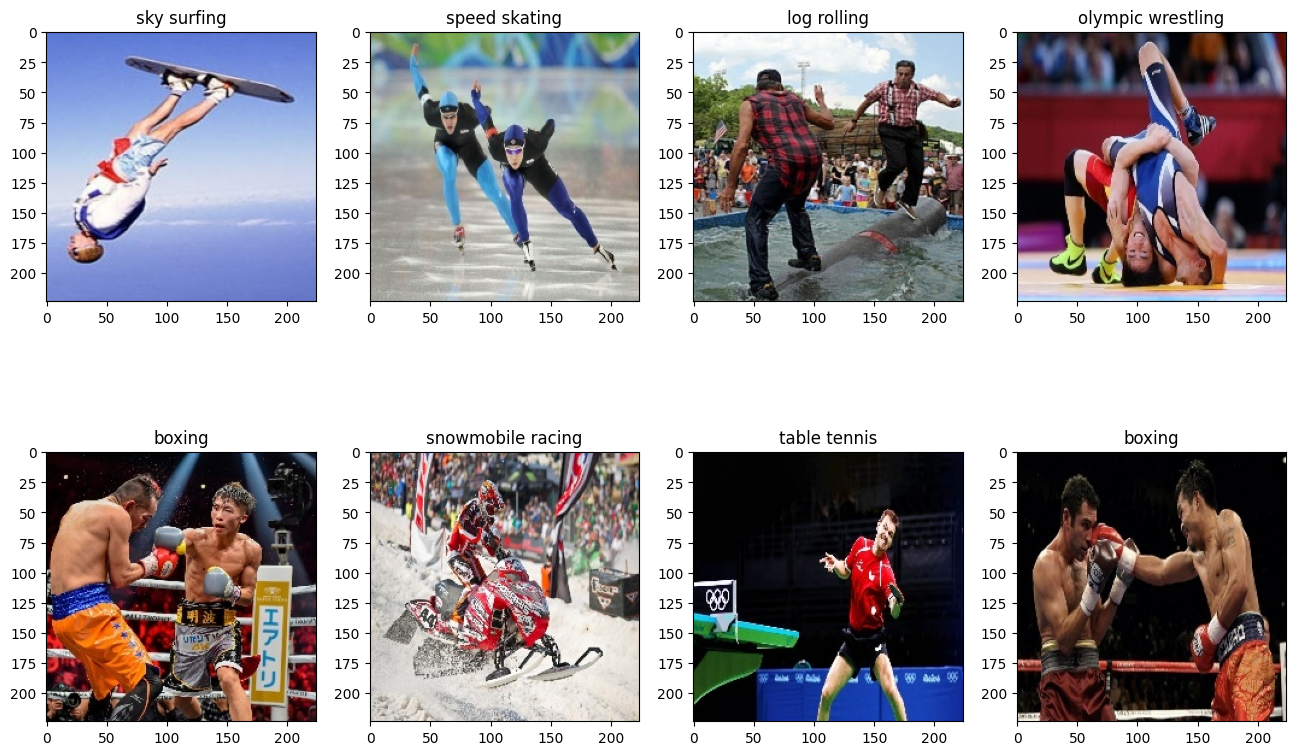

In [8]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
print(test_dataset.__len__())
_, ax = plt.subplots(2, 4, figsize=(16,10))

for i in range(8):
    data = test_dataset.__getitem__(np.random.choice(range(len(test_dataset))))

    image = data[0].cpu().detach().numpy().transpose(1, 2, 0) * 255
    image = image.astype(np.uint32)

    label = data[1]

    ax[i//4][i-(i//4)*4].imshow(image)
    ax[i//4][i-(i//4)*4].set_title(class_names[label])

In [9]:
def performance_test(model, criterion, test_loader, device):
    model.to(device)
    model.eval()
    test_loss = 0
    total = 0
    correct_top1=0
    correct_top5=0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            
            # Top-1 и Top-5 accuracy
            _, predicted = outputs.topk(5, dim=1)
            total += labels.size(0)
            correct_top1 += predicted[:, 0].eq(labels).sum().item()
            correct_top5 += predicted.eq(labels.view(-1, 1)).sum().item()

        test_loss /= len(test_loader)
        top1_accuracy = correct_top1 / total
        top5_accuracy = correct_top5 / total
        
        print(f'Loss: {test_loss:.2f}, acc@1: {top1_accuracy}, acc@5: {top5_accuracy}')

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = LabelSmoothingCrossEntropy()

performance_test(model, criterion, test_loader, device)

100%|██████████| 16/16 [00:04<00:00,  3.70it/s]

Loss: 0.85, acc@1: 0.992, acc@5: 1.0


In [15]:
def speed_test(model, test_dataset, device, batch_size=32, n_repeats=1):
    
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    model.to(device)
    model.eval()
    
    
    with torch.no_grad():
        
        # warm-up
        for images, labels in test_loader:  
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
        start = time.time()
        for i in range(n_repeats):
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
        end = time.time()
        
    mean_time = (end-start)/n_repeats
        
    print(f'Mean time: {mean_time:.5f} s')
    print(f'Mean Speed: {len(test_dataset) / mean_time:.1f} img/s')

In [16]:
speed_test(model, test_dataset, device, batch_size=32, n_repeats=1)

Mean time: 1.83024 s
Mean Speed: 273.2 img/s


In [13]:
def model_size(model):
    size = sum(torch.nn.utils.parameters_to_vector(model.parameters()).size() * 4) / (1024 * 1024)
    print(f'Model size: {size:.5f} Mb')


In [14]:
model_size(model)

Model size: 333.09679 Mb
